In [ ]:
!pip install openpyxl

### Data Loading & Filtering

This section does the following:

- Loads the data dictionary Excel file (`IPEDS_Matched_Data_DictionaryAW.xlsx`)
- Loads the main merged dataset (`merged_dataset_14.csv`)

Then it:
1. Pulls the variable names from the dictionary that are marked as selected (column I = 1).
2. Filters the merged dataset to keep only those selected columns, plus the key ID columns: `unitid` and `year`.
3. Saves the final filtered dataset to a new CSV file for modeling purposes (`merged_dataset_for_modeling.csv`) and provides a download link in Colab.


In [ ]:
import pandas as pd

dict_df = pd.read_excel('IPEDS_Matched_Data_DictionaryAW.xlsx')
merged_df = pd.read_csv('merged_dataset_14.csv', low_memory=False)

selected_vars = dict_df[dict_df.iloc[:, 8] == 1]['CSV_Variable'].dropna().unique().tolist()

id_cols = ['unitid', 'year']
final_cols = id_cols + [col for col in selected_vars if col in merged_df.columns]

filtered_df = merged_df[final_cols]

filtered_df.to_csv('merged_dataset_for_modeling.csv', index=False)

from google.colab import files
files.download('merged_dataset_for_modeling.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Merging cip codes


#### Merging NSF STEM CIP Codes
This part merges the NSF STEM CIP codes with our modeling dataset:
- Loads three files: our modeling dataset, a CIP-year file, and the NSF STEM CIP list.
- Creates a 4-digit CIP code and flags whether it’s a STEM code.
- Saves the result with a new `is_stem` column.

In [ ]:
import pandas as pd

modeling_df = pd.read_csv("/content/merged_dataset_for_modeling.csv")
merged_cip_df = pd.read_csv("/content/merged_cip.csv")
nsf_cip_df = pd.read_excel("/content/NSF CIP codes.xlsx", engine="openpyxl")

merged_cip_df = merged_cip_df.rename(columns={'UNITID': 'unitid'})
nsf_cip_df['CIP Code'] = nsf_cip_df['CIP Code'].astype(str).str[:4]

modeling_with_cip = modeling_df.merge(merged_cip_df, on='unitid', how='left')

modeling_with_cip['cip4'] = modeling_with_cip['CIP'].astype(str).str[:4]

stem_cips = nsf_cip_df['CIP Code'].unique().tolist()
modeling_with_cip['is_stem'] = modeling_with_cip['cip4'].isin(stem_cips).astype(int)

modeling_with_cip.to_csv("/content/modeling_with_stem_indicator.csv", index=False)

modeling_with_cip.head()


,unitid,year,title_iv_indicator,sector,inst_control,offering_highest_degree,hbcu,tribal_college,cc_basic_2000,cc_undergrad_2015,...,typical_board_charge,room_board_charge,exp_sal_wages_from_lib_budget,exp_total_materials_services,exp_total_operation_maint,exp_total,Unnamed: 0,CIP,cip4,is_stem
0,100654,2017,Participates in Title IV federal financial aid...,Public four-year or above,Public,Doctor's degree research/scholarship,Yes,No,Doctoral/research universities intensive,Four-year full-time inclusive lower transfer-in,...,3620.0,NaN,1091789.0,1437469.0,100590.0,2999154.0,3142.0,99.0000,99.0,0
1,100654,2017,Participates in Title IV federal financial aid...,Public four-year or above,Public,Doctor's degree research/scholarship,Yes,No,Doctoral/research universities intensive,Four-year full-time inclusive lower transfer-in,...,3620.0,NaN,1091789.0,1437469.0,100590.0,2999154.0,3481.0,13.1001,13.1,0
2,100654,2017,Participates in Title IV federal financial aid...,Public four-year or above,Public,Doctor's degree research/scholarship,Yes,No,Doctoral/research universities intensive,Four-year full-time inclusive lower transfer-in,...,3620.0,NaN,1091789.0,1437469.0,100590.0,2999154.0,3494.0,50.0702,50.0,0
3,100654,2017,Participates in Title IV federal financial aid...,Public four-year or above,Public,Doctor's degree research/scholarship,Yes,No,Doctoral/research universities intensive,Four-year full-time inclusive lower transfer-in,...,3620.0,NaN,1091789.0,1437469.0,100590.0,2999154.0,3498.0,99.0000,99.0,0
4,100654,2017,Participates in Title IV federal financial aid...,Public four-year or above,Public,Doctor's degree research/scholarship,Yes,No,Doctoral/research universities intensive,Four-year full-time inclusive lower transfer-in,...,3620.0,NaN,1091789.0,1437469.0,100590.0,2999154.0,4739.0,26.1101,26.1,1


#Merging the cips to the datasets merged dataset 14 and merged dataset for modeling

#### Extracting HSI Status from DoE Eligibility Matrices (2018–2022)
Loops through each year’s Excel file to:
- Search for `unitid` and a column with "HSI elig".
- Classifies institutions into:
  - `HSI` (code 5 or 6)
  - `Emerging HSI` (code 4)
  - `Not HSI` (code 1–3 or anything else)
- Saves the final HSI status data to `hsi_flags_by_year.csv`.

In [ ]:
import pandas as pd

files = {
    2018: "/content/copyof2018eligibilitymatrix.xlsx",
    2019: "/content/2019eligibilitymatrix.xlsx",
    2020: "/content/2020eligibilitymatrix.xlsx",
    2021: "/content/2021eligibilitymatrix.xlsx",
    2022: "/content/2022eligibilitymatrix.xlsx"
}

eligibility_data = []

for year, path in files.items():
    print(f"\nProcessing {year} from {path}")

    all_sheets = pd.read_excel(path, sheet_name=None)
    for sheet_name, sheet_df in all_sheets.items():
        print(f"  - Sheet: {sheet_name}")
        col_list = sheet_df.columns.str.lower().tolist()
        print(f"    Columns: {col_list[:10]}...")

        if "unitid" in col_list:
            hsi_col = next((col for col in col_list if "hsi" in col and "elig" in col), None)
            if not hsi_col:
                hsi_col = next((col for col in col_list if col.startswith("hsi")), None)
            if hsi_col:
                print(f"    ✅ Found columns: unitid and {hsi_col}")
                df = sheet_df.copy()
                df.columns = df.columns.str.strip().str.lower()

                hsi_df = df[["unitid", hsi_col]].copy()
                hsi_df.columns = ["unitid", "hsi_code"]
                hsi_df["year"] = year

                def classify(code):
                    try:
                        code = int(code)
                        if code in [5, 6]:
                            return "HSI"
                        elif code == 4:
                            return "Emerging HSI"
                        else:
                            return "Not HSI"
                    except:
                        return "Not HSI"

                hsi_df["hsi_status"] = hsi_df["hsi_code"].apply(classify)
                eligibility_data.append(hsi_df[["unitid", "year", "hsi_status"]])
                break

if eligibility_data:
    hsi_all_years = pd.concat(eligibility_data, ignore_index=True)
    hsi_all_years.to_csv("/content/hsi_flags_by_year.csv", index=False)
    print("\n✅ Saved HSI flag file!")
    hsi_all_years.head()
else:
    print("\n❌ No valid HSI data found in any sheet.")



Processing 2018 from /content/copyof2018eligibilitymatrix.xlsx
  - Sheet: Eligibility Matrix 2018
    Columns: ['unnamed: 0', 'unnamed: 1', 'unnamed: 2', 'unnamed: 3', 'unnamed: 4', 'unnamed: 5', 'unnamed: 6', 'unnamed: 7', 'unnamed: 8', 'unnamed: 9']...
  - Sheet: 2018 Statistics
    Columns: ['unnamed: 0', 'unnamed: 1', 'unnamed: 2', 'unnamed: 3', 'unnamed: 4', 'unnamed: 5', 'unnamed: 6', 'unnamed: 7', 'unnamed: 8', 'aanapisi elig']...
  - Sheet: Program Interactions
    Columns: ['unnamed: 0', 'unnamed: 1', 'unnamed: 2', 'unnamed: 3', 'unnamed: 4', 'unnamed: 5', 'unnamed: 6', 'pending an institution of higher education meets the requirements for title iii, v, and vii eligibility, the following could still happen.', 'unnamed: 8', 'unnamed: 9']...
  - Sheet: Program Eligibility
    Columns: ['unnamed: 0', 'unnamed: 1', 'unnamed: 2', 'unnamed: 3', 'unnamed: 4', 'unnamed: 5', 'unnamed: 6', 'cell fill codes:', 'unnamed: 8', 'unnamed: 9']...

Processing 2019 from /content/2019eligibility

This block below loads the 2020 eligibility matrix, cleans the `unitid`, `HSI`, and `HSI STEM` columns, and saves the clean result as a CSV. We use this in the HSI compilation step later.


In [ ]:
import pandas as pd

df_2020 = pd.read_excel('/content/2020eligibilitymatrix.xlsx', sheet_name='Just Program Eligibility', header=11)

df_2020 = df_2020[['UnitID', 'HSI', 'HSI STEM']].copy()
df_2020.columns = ['unitid', 'hsi_code', 'hsi_stem_code']
df_2020 = df_2020.dropna(subset=['unitid'])

df_2020['unitid'] = df_2020['unitid'].astype(int)
df_2020['hsi_code'] = pd.to_numeric(df_2020['hsi_code'], errors='coerce')
df_2020['hsi_stem_code'] = pd.to_numeric(df_2020['hsi_stem_code'], errors='coerce')

print(df_2020.head())
df_2020.to_csv('/content/eligibility_2020_clean.csv', index=False)


   unitid  hsi_code  hsi_stem_code
0  177834       2.0            2.0
1  180203       3.0            1.0
2  222178       1.0            1.0
3  138558       1.0            1.0
4  451079       2.0            2.0


### HSI Eligibility Matrix (2017–2021) — Full Merge

This block loads and cleans the HSI eligibility matrix files from 2017 to 2021. For each year, it:
- Extracts the relevant HSI eligibility and HSI STEM columns.
- Standardizes column names and data types (like `unitid` as `int`).
- Assigns the correct year to each row.
- Combines all the years into one DataFrame.

This gives us a clean, multi-year file of HSI codes we can merge with other datasets later. The final merged result is saved to:



In [ ]:
import pandas as pd

# === 2017 ===
df_2017 = pd.read_csv('/content/Copy of em2017.csv', skiprows=14, encoding='latin1')
df_2017.columns = df_2017.columns.str.strip().str.lower()
df_2017 = df_2017[['unit id', 'hsi elig', 'hsi stem elig']].dropna(subset=['unit id'])
df_2017.columns = ['unitid', 'hsi_code', 'hsi_stem_code']
df_2017['unitid'] = df_2017['unitid'].astype(int)
df_2017['year'] = 2017

# === 2018 ===
df_2018 = pd.read_excel('/content/copyof2018eligibilitymatrix.xlsx', sheet_name='Eligibility Matrix 2018', header=14)
df_2018 = df_2018[['Unit ID', 'HSI Elig', 'HSI Stem Elig']].dropna(subset=['Unit ID'])
df_2018.columns = ['unitid', 'hsi_code', 'hsi_stem_code']
df_2018['unitid'] = df_2018['unitid'].astype(int)
df_2018['year'] = 2018

# === 2019 ===
df_2019 = pd.read_excel('/content/2019eligibilitymatrix.xlsx', sheet_name='Program Eligibility', header=14)
df_2019 = df_2019[['Unit ID', 'HSI Elig', 'HSI Stem Elig']].dropna(subset=['Unit ID'])
df_2019.columns = ['unitid', 'hsi_code', 'hsi_stem_code']
df_2019['unitid'] = df_2019['unitid'].astype(int)
df_2019['year'] = 2019

# === 2020 ===
df_2020 = pd.read_excel('/content/2020eligibilitymatrix.xlsx', sheet_name='Just Program Eligibility', header=11)
df_2020 = df_2020[['UnitID', 'HSI', 'HSI STEM']].dropna(subset=['UnitID'])
df_2020.columns = ['unitid', 'hsi_code', 'hsi_stem_code']
df_2020['unitid'] = df_2020['unitid'].astype(int)
df_2020['year'] = 2020

# === 2021 ===
df_2021 = pd.read_excel('/content/2021eligibilitymatrix.xlsx', sheet_name='2021_Eligibility_Matrix', header=10)
df_2021.columns = df_2021.columns.str.strip().str.lower()
df_2021 = df_2021[['unitid', 'hsi', 'hsi stem (f)']].dropna(subset=['unitid'])
df_2021.columns = ['unitid', 'hsi_code', 'hsi_stem_code']
df_2021['unitid'] = df_2021['unitid'].astype(int)
df_2021['year'] = 2021

# === Combine all years ===
compiled = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021], ignore_index=True)
compiled.to_csv('/content/hsi_cleaned_compiled.csv', index=False)

print(" Saved merged HSI data with all years to /content/hsi_cleaned_compiled.csv")


✅ Saved merged HSI data with all years to /content/hsi_cleaned_compiled.csv


We calculate HSI classification using the Excellencia method:
- Load the fall enrollment file.
- Filter to full-time undergrads only.
- Compute Hispanic % based on full-time Hispanic enrollment.
- Label institutions as `HSI`, `Emerging HSI`, or `Not HSI` based on thresholds (25% and 15%).

In [ ]:
import pandas as pd

fall = pd.read_csv('/content/fall-enrollment-res_filtered.csv')

fall = fall[
    (fall['level_of_study'].str.lower() == 'undergraduate') &
    (fall['sex'].str.lower() == 'total')
]

total_ft = fall.groupby(['unitid', 'year'])['headcount'].sum().reset_index()
total_ft.rename(columns={'headcount': 'total_ft_undergrads'}, inplace=True)

hisp_ft = fall[fall['race'].str.lower() == 'hispanic']
hisp_ft = hisp_ft.groupby(['unitid', 'year'])['headcount'].sum().reset_index()
hisp_ft.rename(columns={'headcount': 'hispanic_ft_undergrads'}, inplace=True)

merged = total_ft.merge(hisp_ft, on=['unitid', 'year'], how='left')
merged['hispanic_ft_undergrads'] = merged['hispanic_ft_undergrads'].fillna(0)

merged['hispanic_percent'] = merged['hispanic_ft_undergrads'] / merged['total_ft_undergrads'] * 100

def classify(percent):
    if percent >= 25:
        return 'HSI'
    elif 15 <= percent < 25:
        return 'Emerging HSI'
    else:
        return 'Not HSI'

merged['excellencia_hsi_status'] = merged['hispanic_percent'].apply(classify)

merged.to_csv('/content/excellencia_classified_hsi.csv', index=False)

print(merged.head())


   unitid    year  total_ft_undergrads  hispanic_ft_undergrads  \
0  100654  2017.0              10686.0                    48.0   
1  100654  2018.0               5170.0                    48.0   
2  100663  2017.0              28890.0                   478.0   
3  100663  2018.0              12721.0                   510.0   
4  100690  2017.0                880.0                     8.0   

   hispanic_percent excellencia_hsi_status  
0          0.449186                Not HSI  
1          0.928433                Not HSI  
2          1.654552                Not HSI  
3          4.009119                Not HSI  
4          0.909091                Not HSI  


We merge the Excellencia-based HSI labels into our main dataset (`modeling_with_hsi.csv`) so we can compare them side by side with the Dept of Ed ones later.


In [ ]:
modeling = pd.read_csv('/content/modeling_with_hsi.csv')
excellencia = pd.read_csv('/content/excellencia_classified_hsi.csv')

# standardize column names
modeling.columns = modeling.columns.str.lower().str.strip()
excellencia.columns = excellencia.columns.str.lower().str.strip()

# merge on unitid and year
merged = modeling.merge(excellencia[['unitid', 'year', 'excellencia_hsi_status']],
                        on=['unitid', 'year'],
                        how='left')

# save
merged.to_csv('/content/modeling_with_hsi_combined.csv', index=False)

# check
merged['excellencia_hsi_status'].value_counts(dropna=False)


<ipython-input-4-5b65e346ae95>:2: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  modeling = pd.read_csv('/content/modeling_with_hsi.csv')


,count
excellencia_hsi_status,
NaN,27712
Not HSI,10467
HSI,1020
Emerging HSI,748


This block checks where the Dept of Ed HSI codes (`hsi_code`) are missing and compares the breakdown across:
- `sector` (like 2-year vs 4-year)
- `cc_basic_2000` (Carnegie Classification)

We get tables showing how many schools are missing or have valid HSI codes for each category.

In [ ]:
import pandas as pd

# load dataset
df = pd.read_csv('/content/modeling_with_hsi.csv')

# strip and lowercase column names
df.columns = df.columns.str.strip().str.lower()

# filter out rows with missing hsi_code
missing_hsi = df[df['hsi_code'].isna()]
present_hsi = df[df['hsi_code'].notna()]

# quick value lookup if you're not sure what values are in 'sector' and 'cc_basic_2000'
print("Sector values:\n", df['sector'].dropna().unique())
print("\nCC Basic 2000 values:\n", df['cc_basic_2000'].dropna().unique())

# group by 'sector' and count
missing_by_sector = missing_hsi['sector'].value_counts(dropna=False).rename('missing_hsi_count')
present_by_sector = present_hsi['sector'].value_counts(dropna=False).rename('present_hsi_count')

# merge to compare side by side
sector_comparison = pd.concat([missing_by_sector, present_by_sector], axis=1).fillna(0).astype(int)

# Do the same for 'cc_basic_2000'
missing_by_cc = missing_hsi['cc_basic_2000'].value_counts(dropna=False).rename('missing_hsi_count')
present_by_cc = present_hsi['cc_basic_2000'].value_counts(dropna=False).rename('present_hsi_count')

cc_comparison = pd.concat([missing_by_cc, present_by_cc], axis=1).fillna(0).astype(int)

# Display both
print("\n=== Sector Comparison ===")
print(sector_comparison)

print("\n=== CC Basic 2000 Comparison ===")
print(cc_comparison)


Sector values:
 ['Public four-year or above' 'Private not-for-profit four-year or above'
 'Administrative unit' 'Public two-year'
 'Private for-profit four-year or above'
 'Private for-profit less-than-two-year' 'Private for-profit two-year'
 'Public less-than two-year' 'Private not-for-profit two-year'
 'Private not-for-profit less-than-two-year' 'Sector unknown (not active)']

CC Basic 2000 values:
 ['Doctoral/research universities intensive'
 'Doctoral/research universities extensive'
 'Theological seminaries and other specialized faith-related institutions'
 'Masters colleges and universities I' 'Missing/not reported'
 'Not applicable' "Associate's colleges" 'Baccalaureate colleges general'
 'Baccalaureate colleges liberal arts'
 "Baccalaureate/associate's colleges" 'Other specialized institutions'
 'Schools of business and management'
 'Schools of engineering and technology' 'Tribal colleges'
 'Masters colleges and universities II'
 'Medical schools and medical centers' 'Schools o

<ipython-input-5-5602d842371f>:4: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/modeling_with_hsi.csv')


We turn the comparisons above into **visuals**! It makes it easier to spot patterns in which types of institutions are missing HSI classifications. We generate two horizontal stacked bar plots:
- One for `sector`
- One for `cc_basic_2000`

Really useful for checking if most missing schools are community colleges.

# New Data with ef17 through ef22

## Merging Data first and updating column excellencia_hsi_status

In [ ]:
import pandas as pd

# we load the  main dataset
hsi_combined = pd.read_csv("modeling_with_hsi_combined.csv", low_memory=False)
hsi_combined.columns = hsi_combined.columns.str.strip().str.lower()

# process ef17 to ef22 with decimal thresholds
def map_status(p):
    if p < 0.15:
        return 'Not HSI'
    elif p < 0.25:
        return 'Emerging HSI'
    else:
        return 'HSI'

ef_all = []

for year in range(2017, 2023):
    ef = pd.read_csv(f"ef{str(year)[-2:]}.csv", low_memory=False)
    ef.columns = ef.columns.str.strip().str.lower()
    ef = ef[['unitid', 'hispperc']].dropna()
    ef['year'] = year
    ef['excellencia_hsi_status'] = ef['hispperc'].apply(map_status)
    ef = ef.drop_duplicates(subset=['unitid', 'year'])
    ef_all.append(ef)

ef_combined = pd.concat(ef_all, ignore_index=True)

# merge updated status into combined dataset
merged = hsi_combined.merge(
    ef_combined[['unitid', 'year', 'excellencia_hsi_status']],
    on=['unitid', 'year'],
    how='left',
    suffixes=('', '_new')
)

# update only where new values exist
merged['excellencia_hsi_status'] = merged['excellencia_hsi_status_new'].fillna(
    merged['excellencia_hsi_status']
)
merged.drop(columns=['excellencia_hsi_status_new'], inplace=True)

# count how many are in each category (including missing)
status_counts = merged['excellencia_hsi_status'].value_counts(dropna=False)
print(status_counts)

merged.to_csv("modeling_with_hsi_combined_updated.csv", index=False)


excellencia_hsi_status
Not HSI         23259
HSI              8867
Emerging HSI     4754
NaN              3067
Name: count, dtype: int64


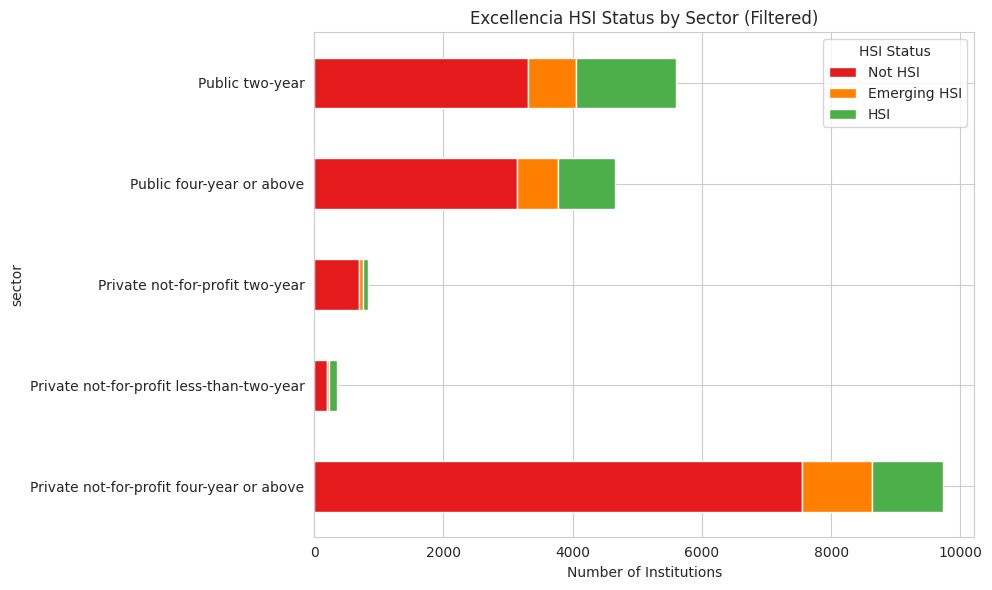

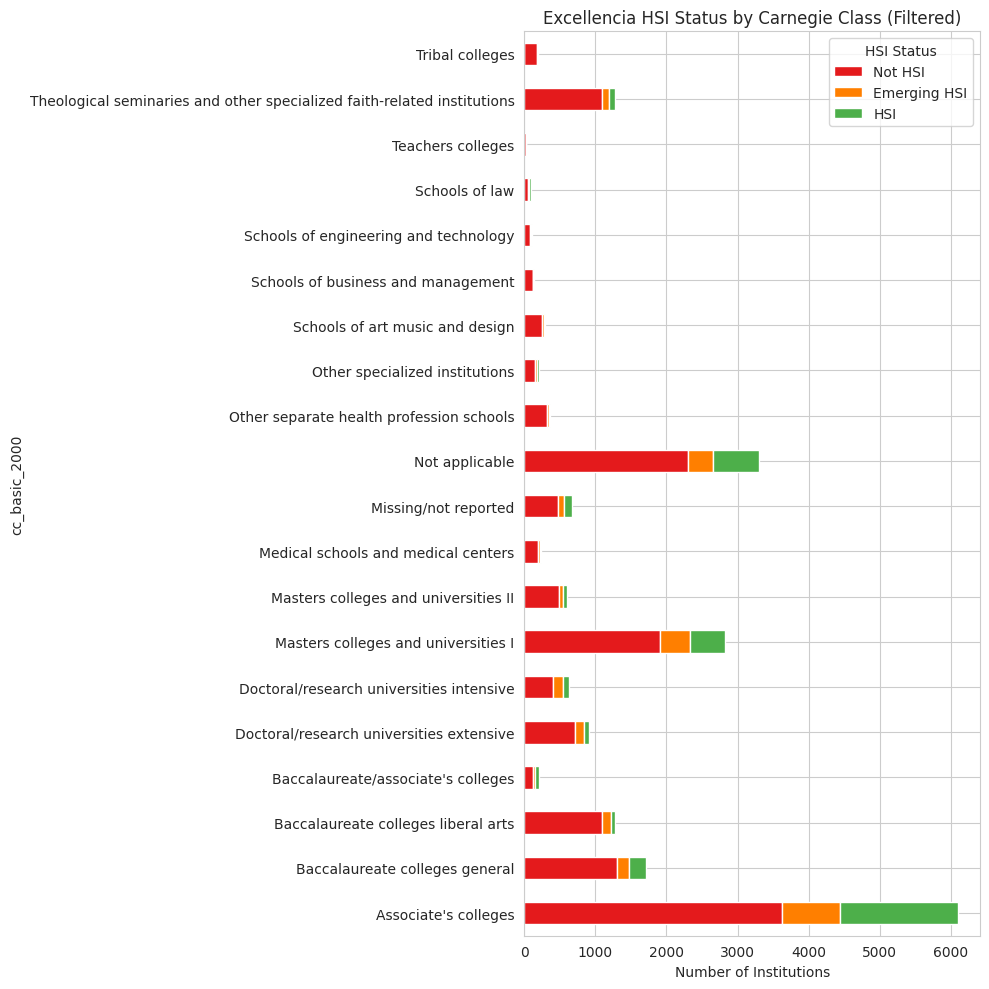

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# load data
df = pd.read_csv("/content/modeling_with_hsi_combined_updated.csv", low_memory=False)
df.columns = df.columns.str.strip().str.lower()
df = df[df['excellencia_hsi_status'].notna()]

excluded = [
    'Administrative unit',
    'Sector unknown (not active)',
    'Private for-profit four-year or above',
    'Private for-profit two-year',
    'Private for-profit less-than-two-year',
    'Public less-than two-year'
]
filtered_df = df[~df['sector'].isin(excluded)]

# custom bright color map
color_map = {
    'Not HSI': '#E41A1C',
    'Emerging HSI': '#FF7F00',
    'HSI': '#4DAF4A'
}

# plot by sector
sector_counts = filtered_df.groupby(['sector', 'excellencia_hsi_status']).size().unstack(fill_value=0)
sector_counts = sector_counts[['Not HSI', 'Emerging HSI', 'HSI']]

fig1, ax1 = plt.subplots(figsize=(10, 6))
sector_counts.plot(kind='barh', stacked=True, ax=ax1, color=[color_map[k] for k in sector_counts.columns])
ax1.set_title('Excellencia HSI Status by Sector (Filtered)')
ax1.set_xlabel('Number of Institutions')
ax1.legend(title='HSI Status')
plt.tight_layout()

# plot by carnegie classification
cc_counts = filtered_df.groupby(['cc_basic_2000', 'excellencia_hsi_status']).size().unstack(fill_value=0)
cc_counts = cc_counts[['Not HSI', 'Emerging HSI', 'HSI']]

fig2, ax2 = plt.subplots(figsize=(10, 10))
cc_counts.plot(kind='barh', stacked=True, ax=ax2, color=[color_map[k] for k in cc_counts.columns])
ax2.set_title('Excellencia HSI Status by Carnegie Class (Filtered)')
ax2.set_xlabel('Number of Institutions')
ax2.legend(title='HSI Status')
plt.tight_layout()

plt.show()


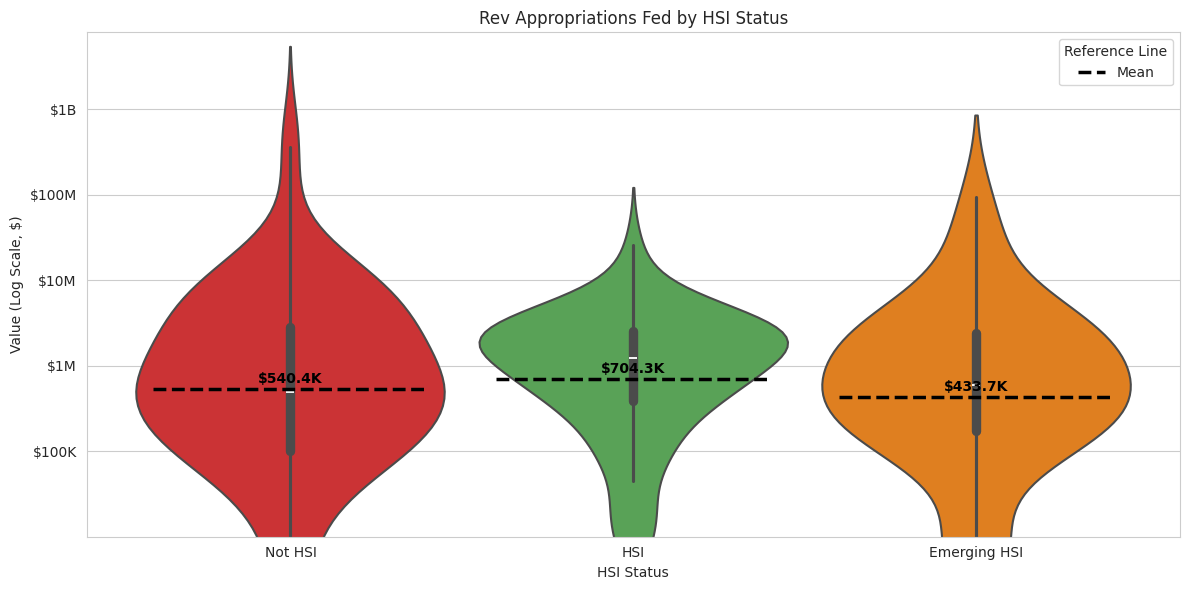

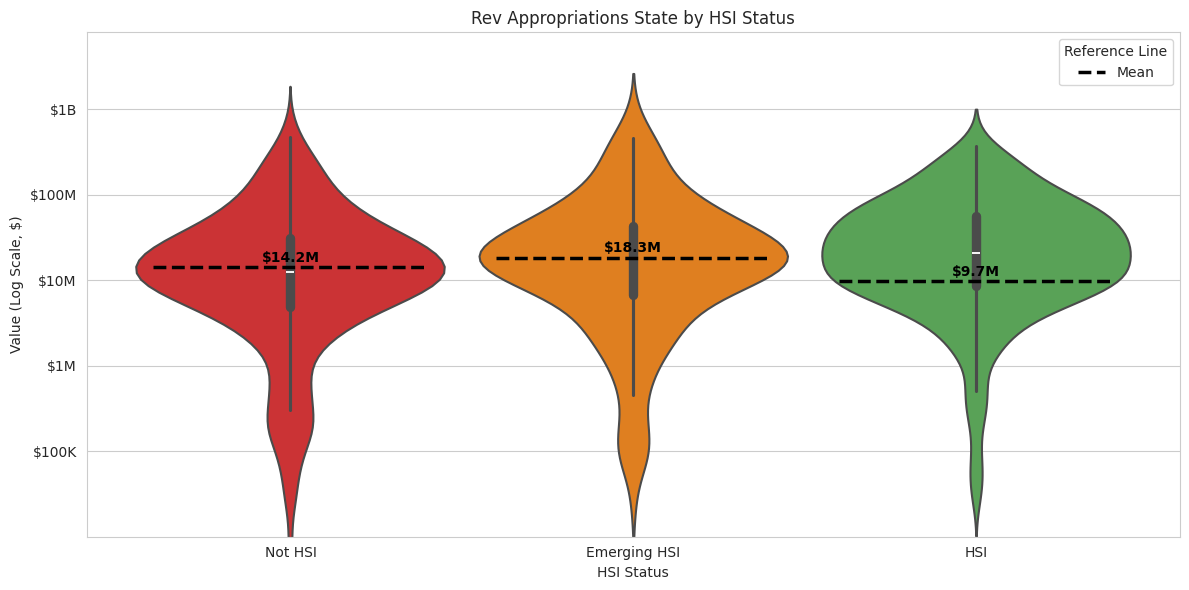

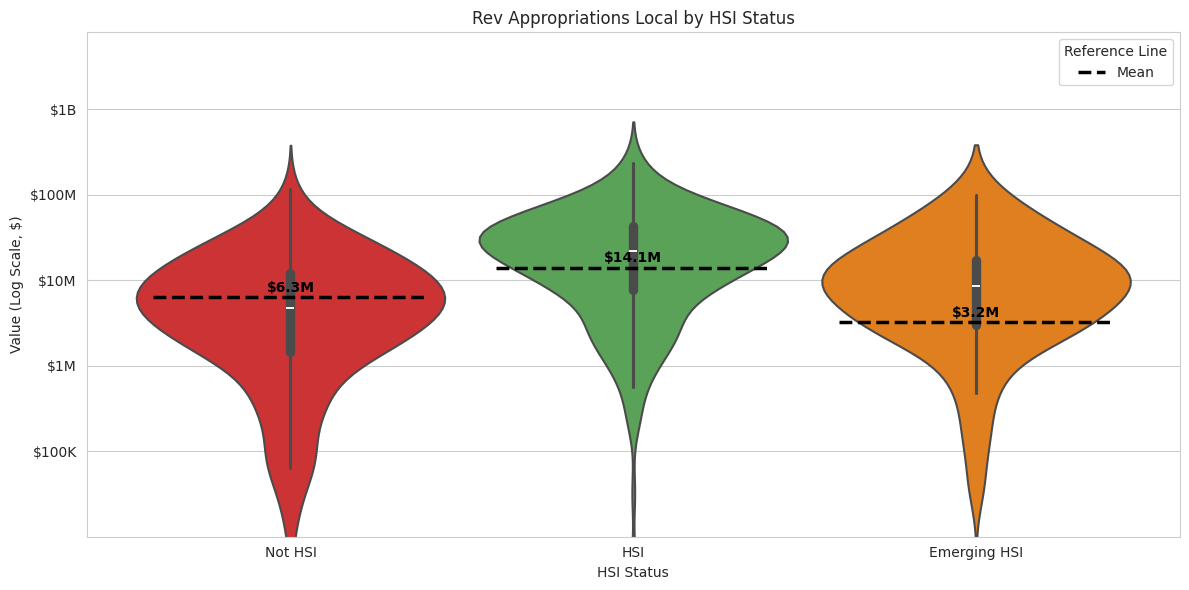

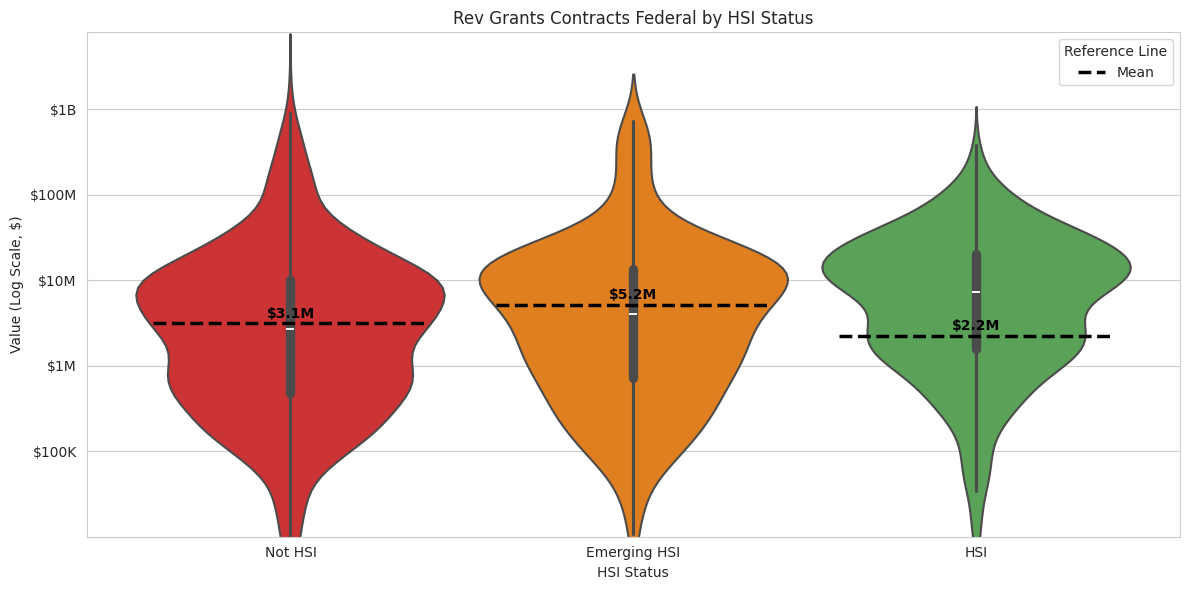

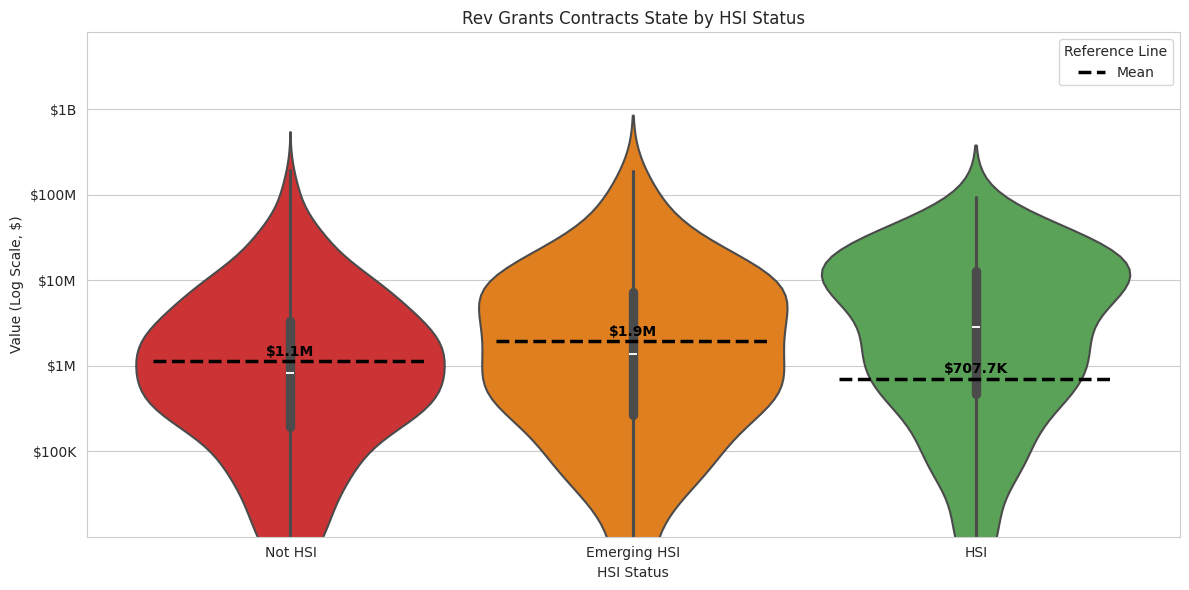

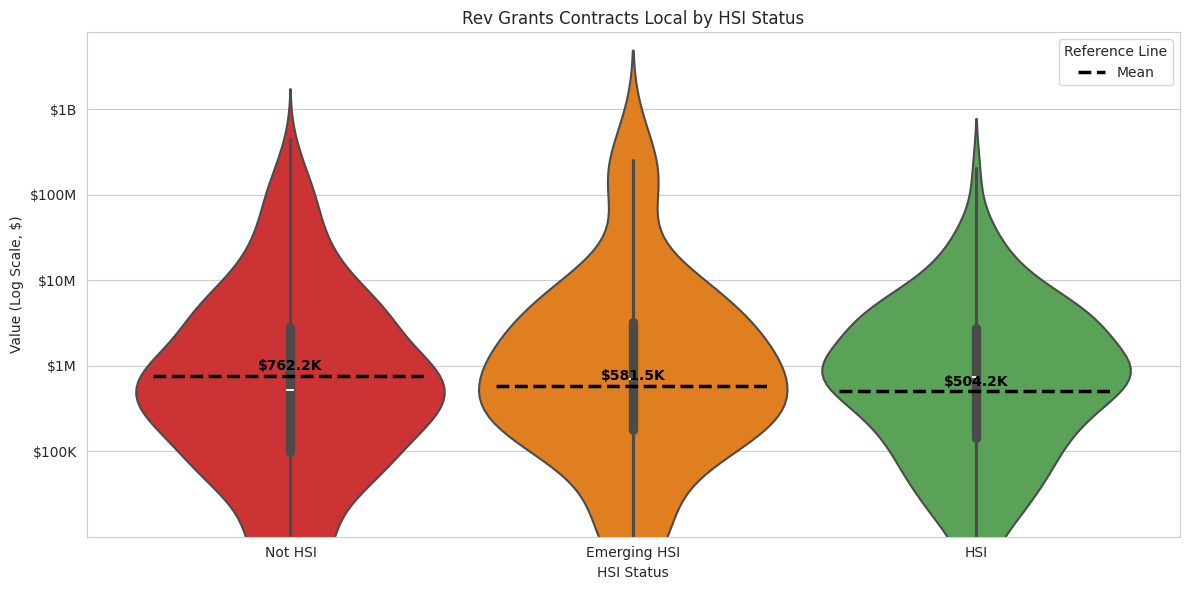

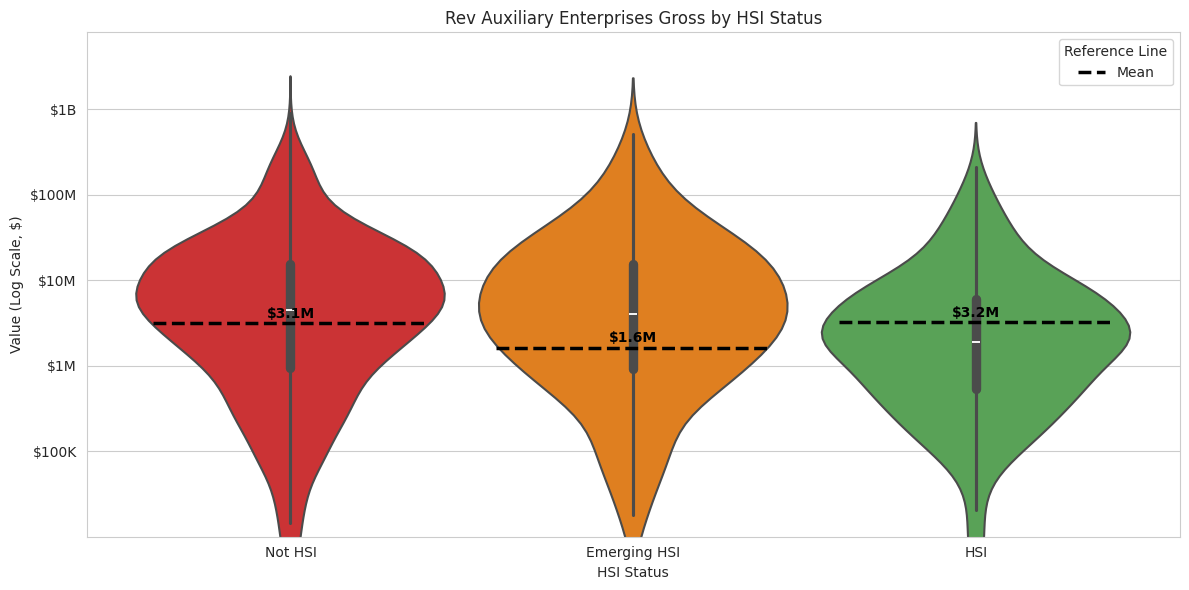

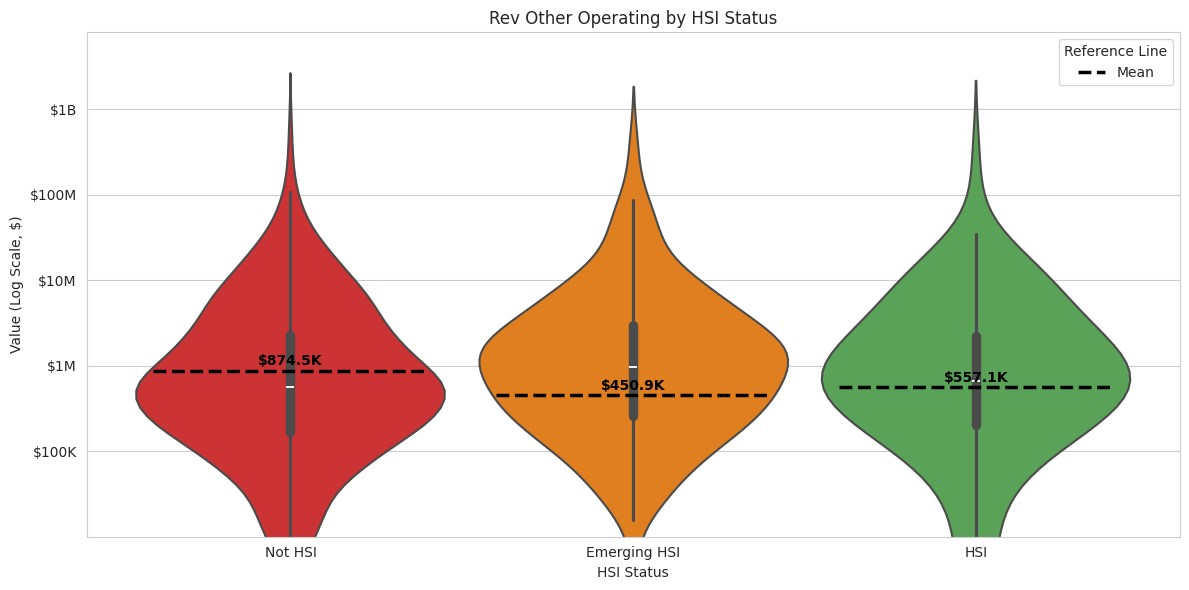

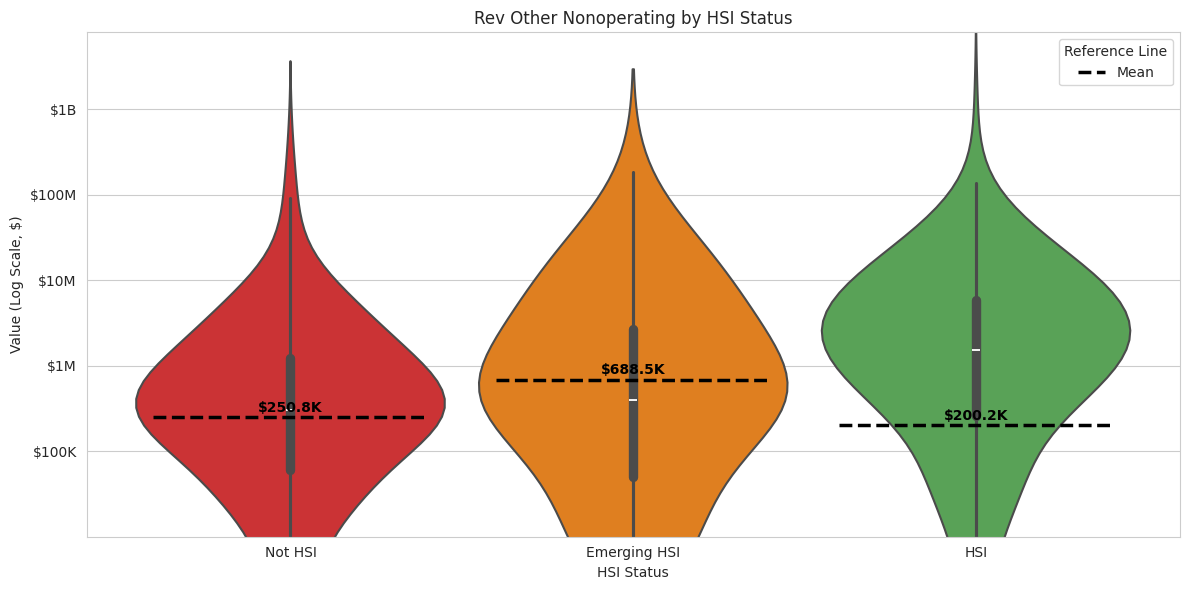

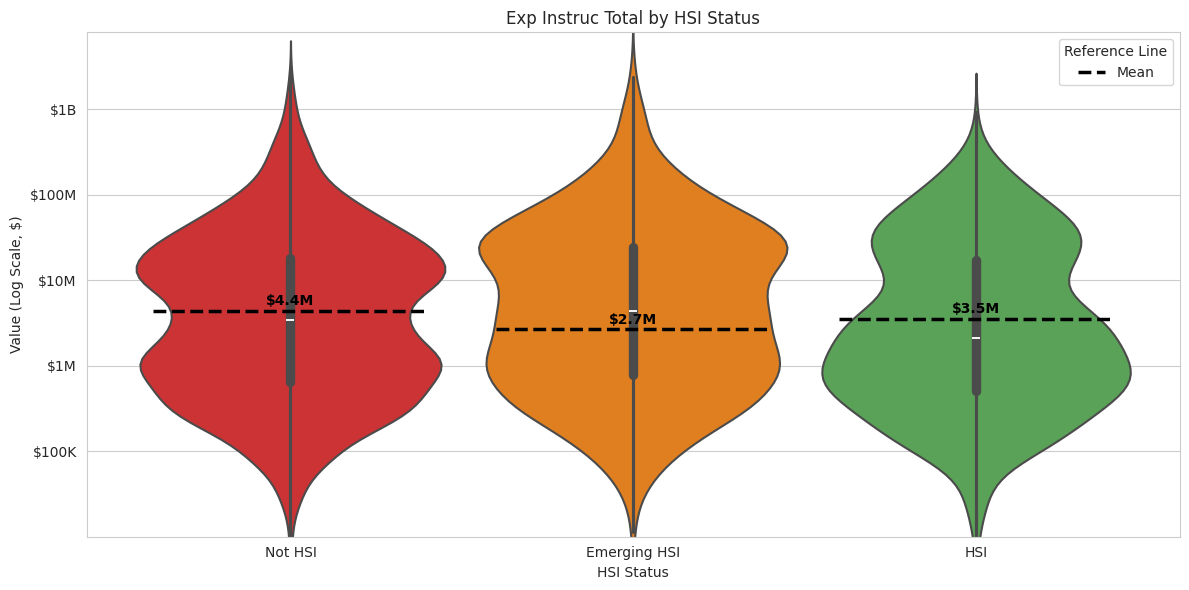

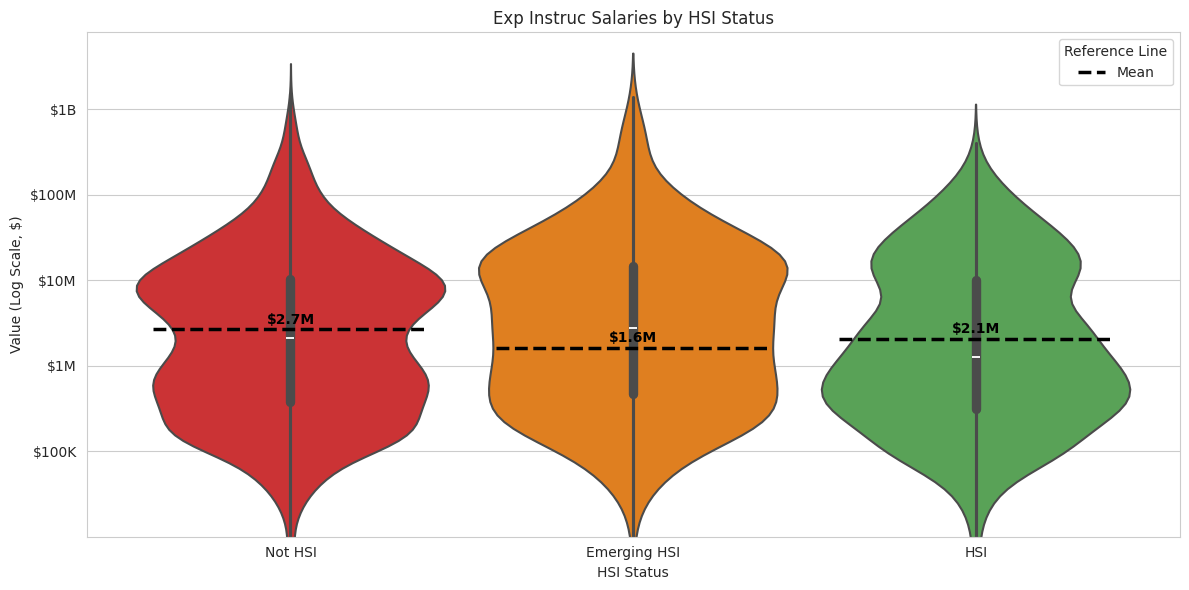

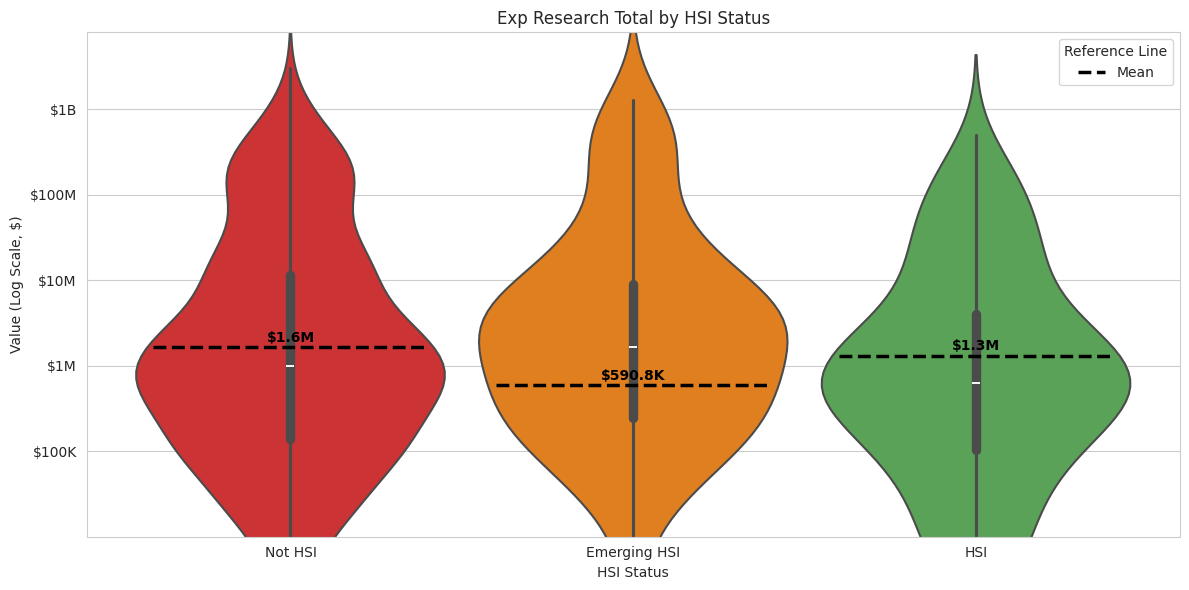

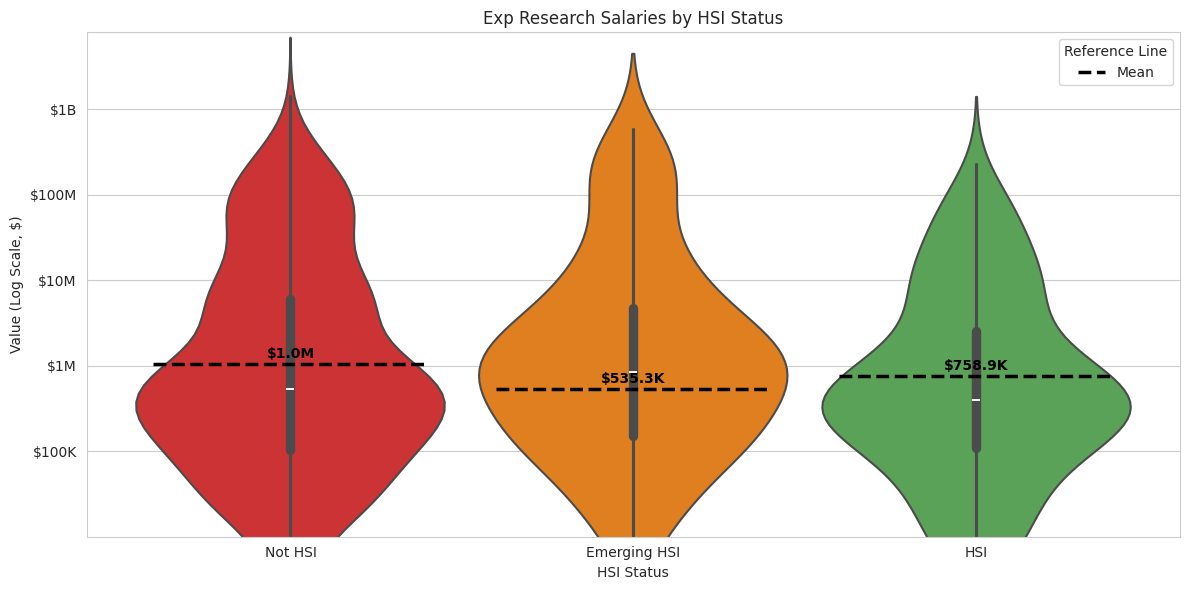

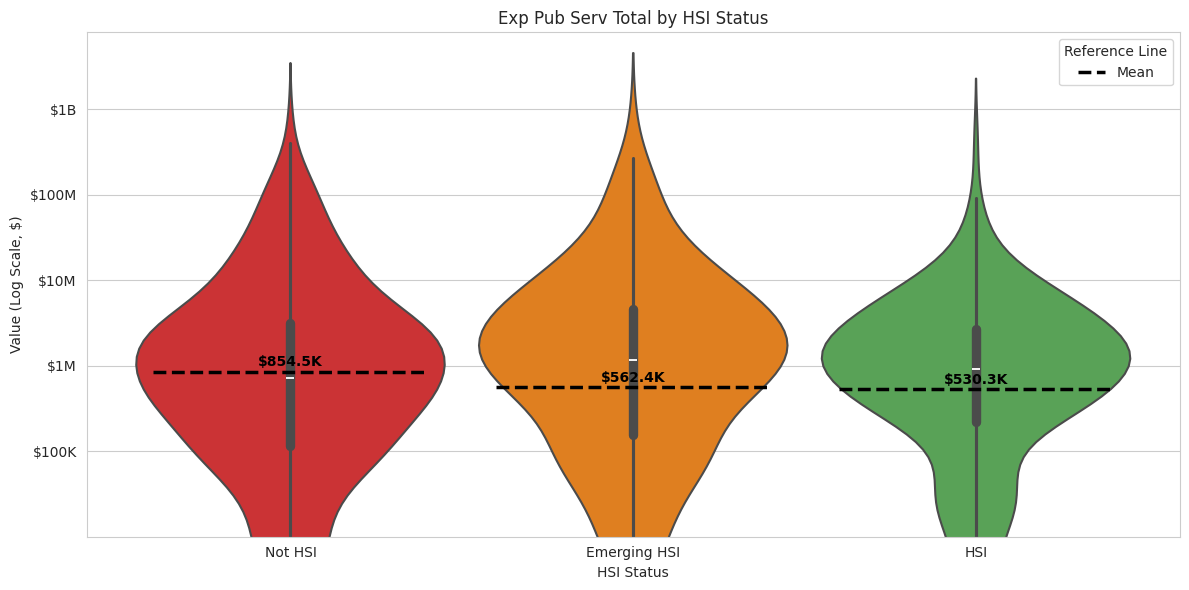

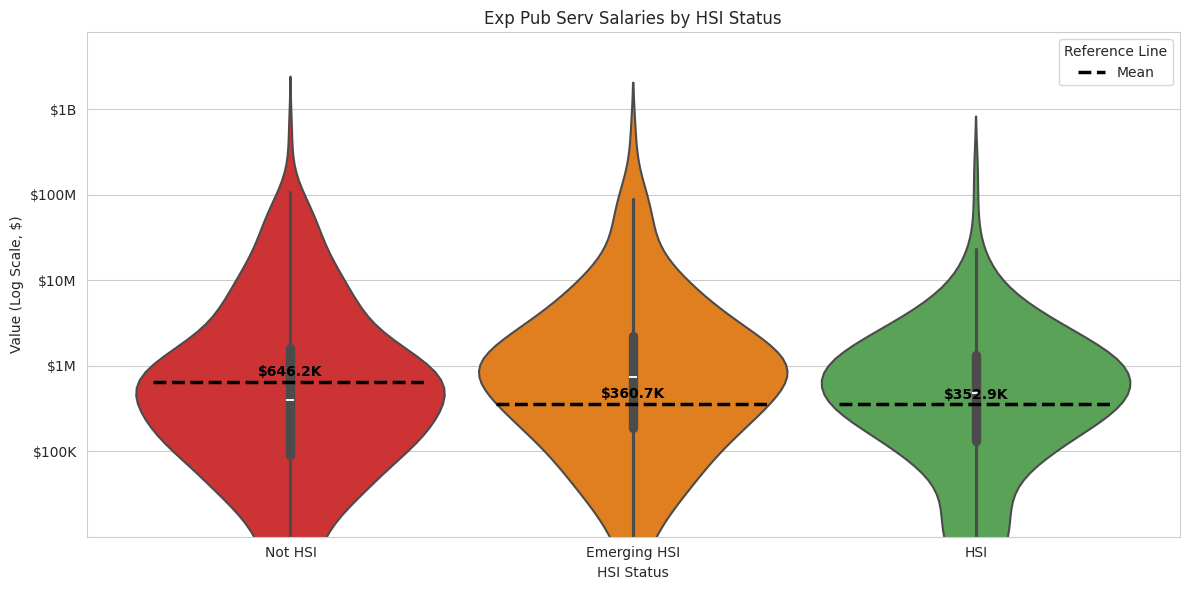

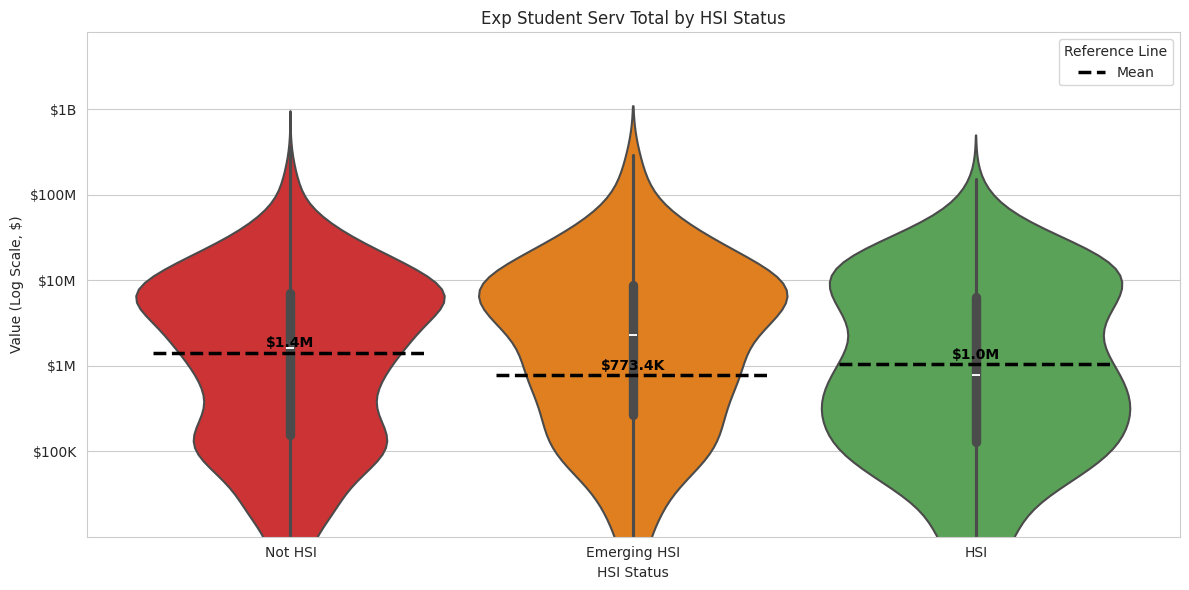

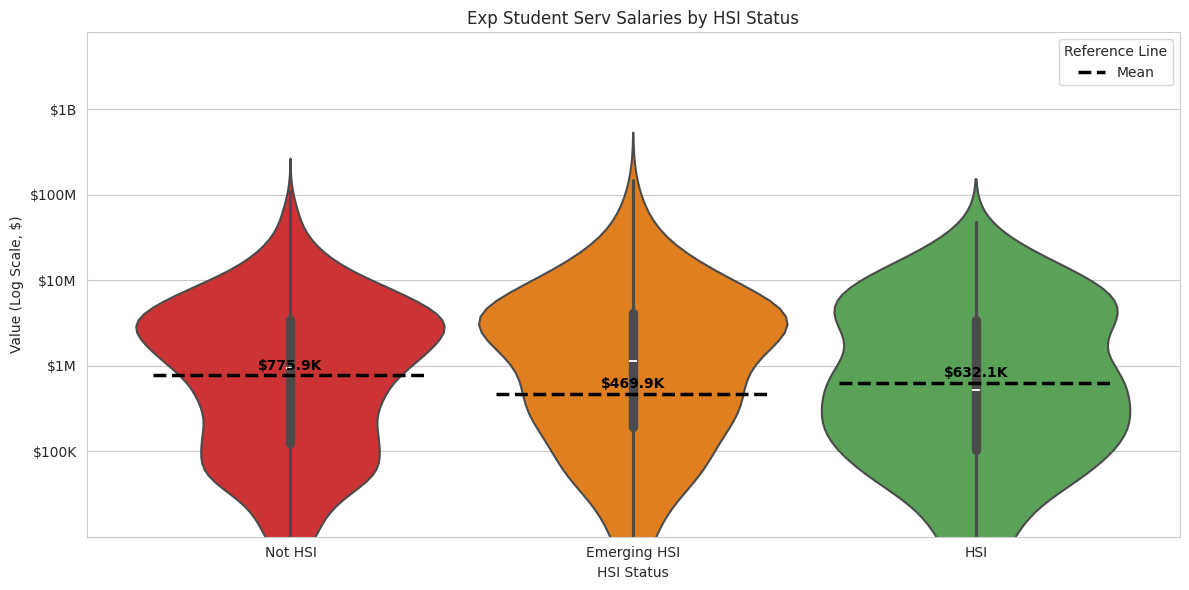

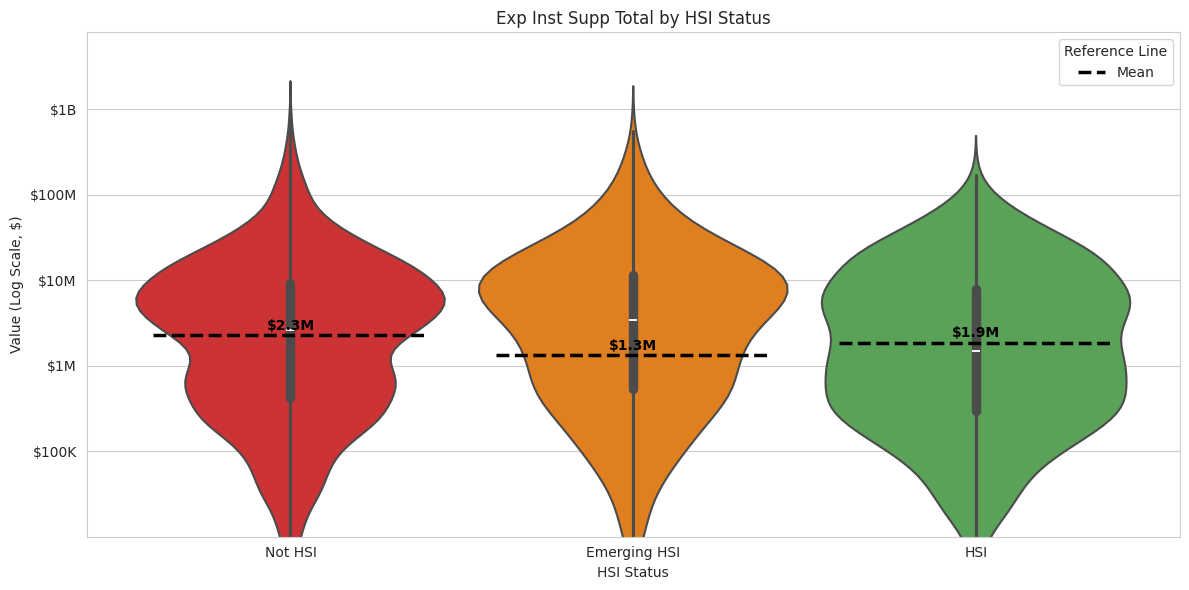

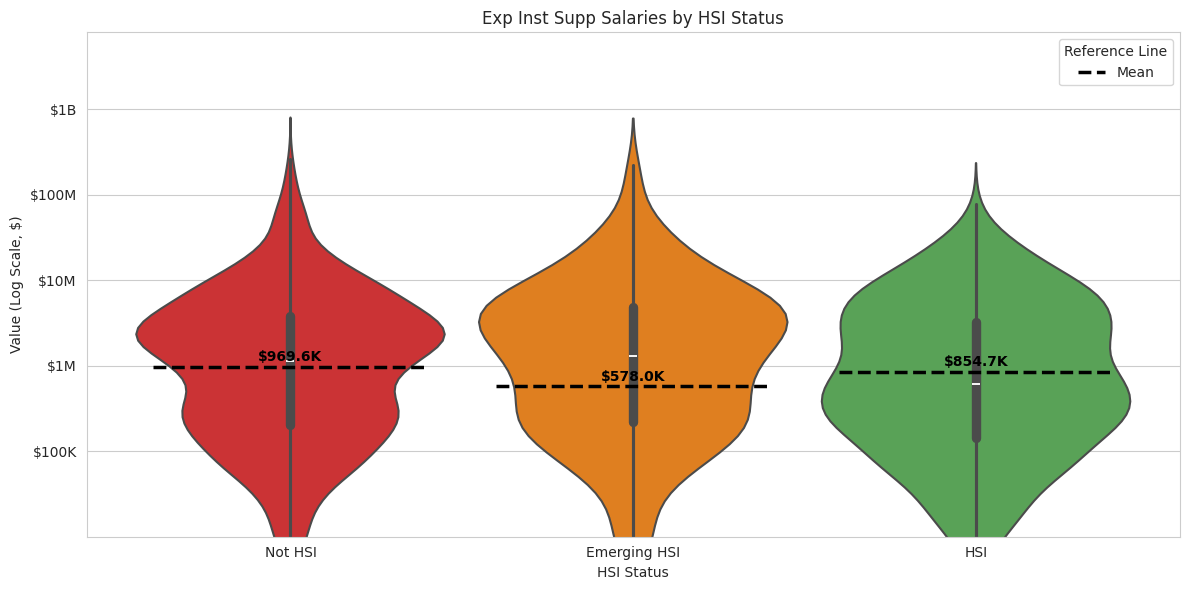

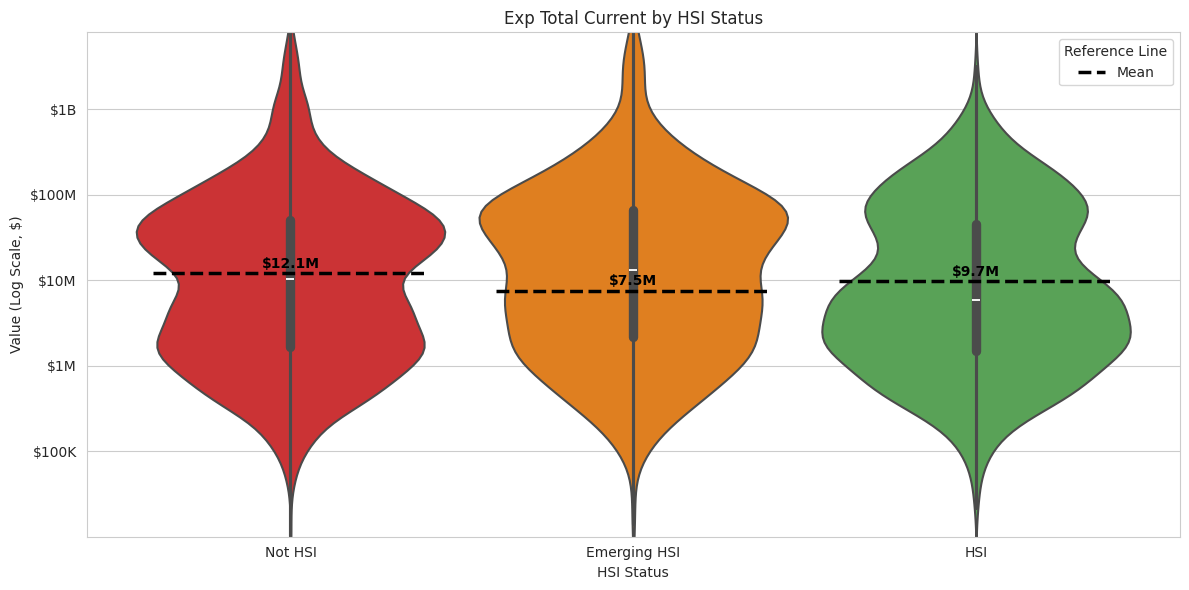

<ipython-input-12-11f3d63dfd70>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['log_value'] = np.log10(temp_df[col])


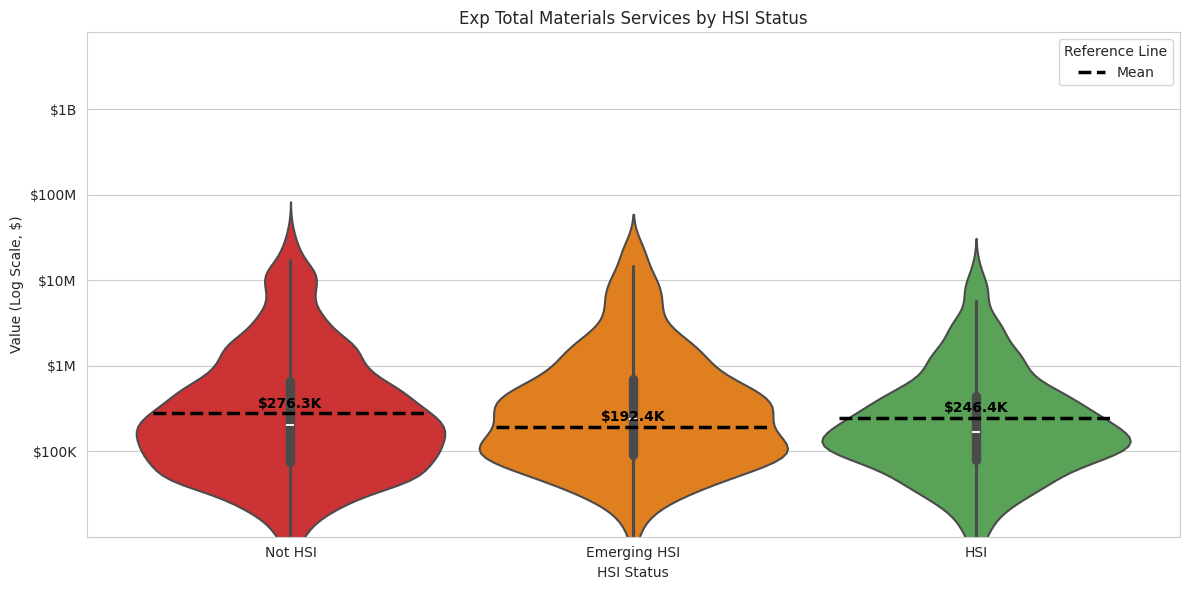

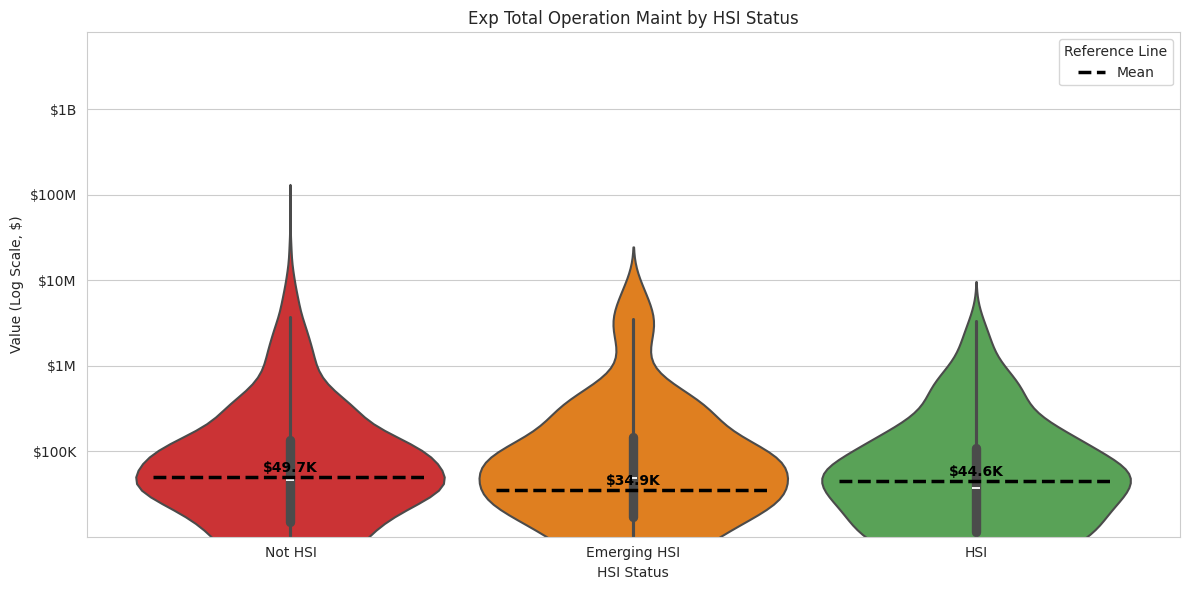

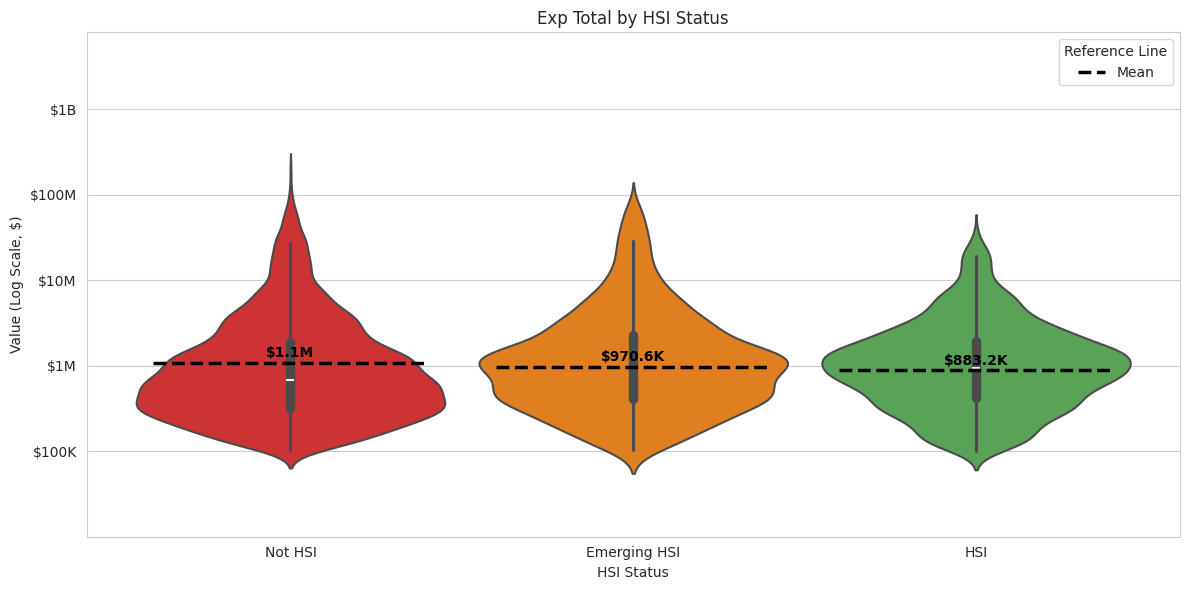

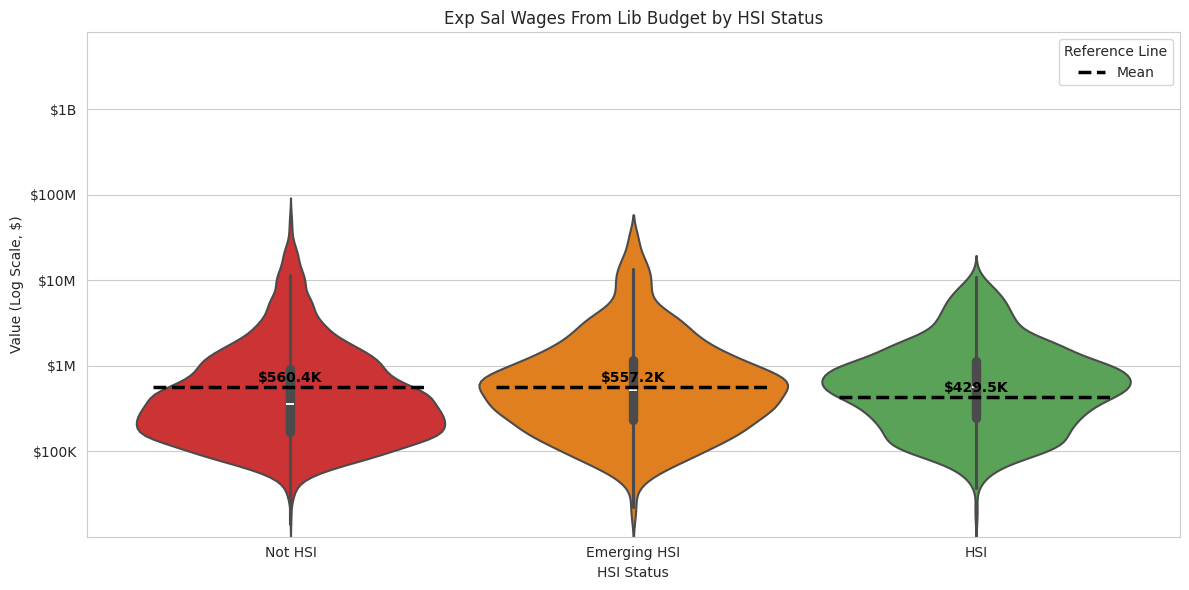

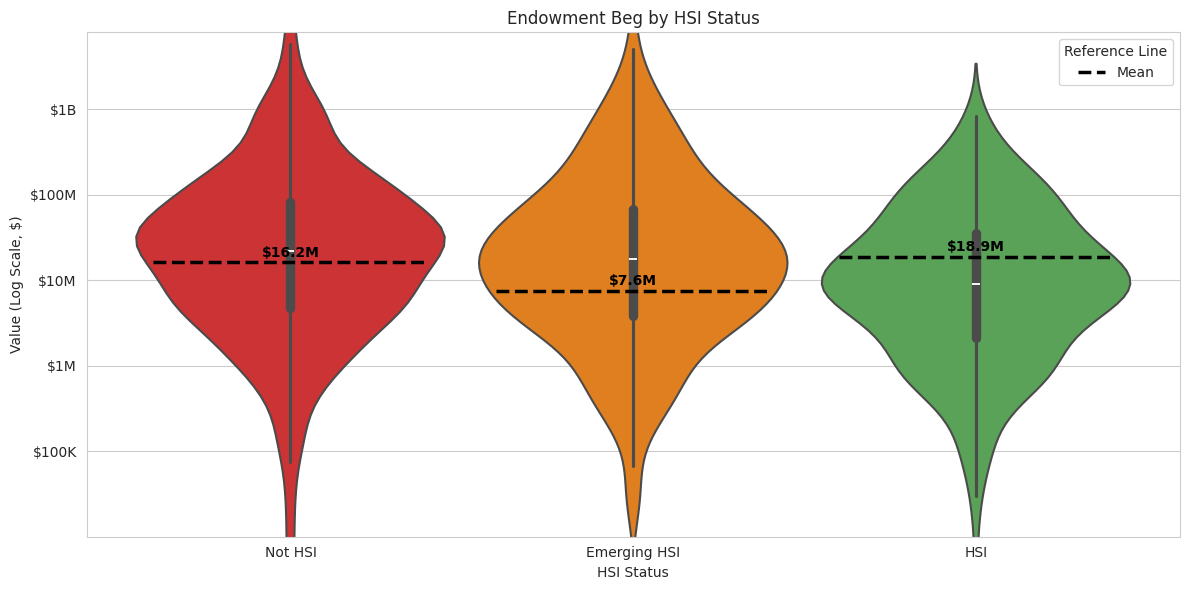

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Load dataset
df = pd.read_csv("/content/modeling_with_hsi_combined_updated.csv", low_memory=False)
df.columns = df.columns.str.strip().str.lower()

# Financial variables
relevant_cols = [
    'rev_appropriations_fed', 'rev_appropriations_state', 'rev_appropriations_local',
    'rev_grants_contracts_federal', 'rev_grants_contracts_state', 'rev_grants_contracts_local',
    'rev_auxiliary_enterprises_gross', 'rev_other_operating', 'rev_other_nonoperating',
    'exp_instruc_total', 'exp_instruc_salaries', 'exp_research_total', 'exp_research_salaries',
    'exp_pub_serv_total', 'exp_pub_serv_salaries', 'exp_student_serv_total',
    'exp_student_serv_salaries', 'exp_inst_supp_total', 'exp_inst_supp_salaries',
    'exp_total_current', 'exp_total_materials_services', 'exp_total_operation_maint',
    'exp_total', 'exp_sal_wages_from_lib_budget', 'endowment_beg'
]

# Styling
sns.set_style('whitegrid')
palette = {'Not HSI': '#E41A1C', 'HSI': '#4DAF4A', 'Emerging HSI': '#FF7F00'}  # Bright, clear colors
y_ticks = [5, 6, 7, 8, 9]
y_tick_labels = ["$100K", "$1M", "$10M", "$100M", "$1B"]

for col in relevant_cols:
    temp_df = df[['excellencia_hsi_status', col]].dropna()
    temp_df = temp_df[temp_df[col] > 0]
    if temp_df.empty:
        continue
    temp_df['log_value'] = np.log10(temp_df[col])
    summary = temp_df.groupby('excellencia_hsi_status')['log_value'].agg(['mean'])

    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(
        data=temp_df,
        x='excellencia_hsi_status',
        y='log_value',
        hue='excellencia_hsi_status',
        palette=palette,
        inner='box',
        width=0.9,
        linewidth=1.5,
        legend=False
    )

    for i, (status, row) in enumerate(summary.iterrows()):
        y_val = row['mean']
        ax.hlines(y=y_val, xmin=i - 0.4, xmax=i + 0.4,
                  colors='black', linestyles='--', linewidth=2.5)
        val = 10 ** y_val
        label = f"${val/1e6:.1f}M" if val >= 1e6 else f"${val/1e3:.1f}K"
        ax.text(i, y_val + 0.03, label,
                color='black', fontsize=10, weight='bold', ha='center', va='bottom')

    ax.set_title(f'{col.replace("_", " ").title()} by HSI Status')
    ax.set_xlabel('HSI Status')
    ax.set_ylabel('Value (Log Scale, $)')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)
    ax.set_ylim(4.0, 9.9)  # Zoomed out more

    # Custom legend
    mean_line = Line2D([0], [0], color='black', linestyle='--', linewidth=2.5)
    ax.legend([mean_line], ['Mean'], title='Reference Line', loc='upper right')

    plt.tight_layout()
    plt.show()
    plt.close()




<ipython-input-8-9a3b4008935c>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_tbl = df.groupby(['year', 'excellencia_hsi_status']).size().unstack(fill_value=0).reindex(columns=order)


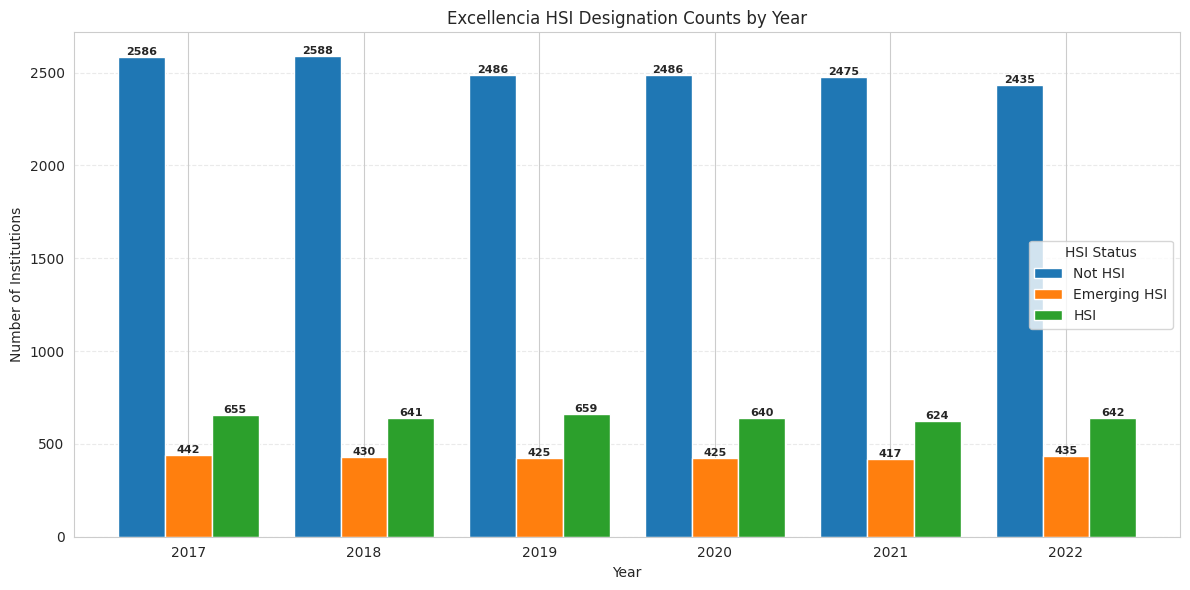

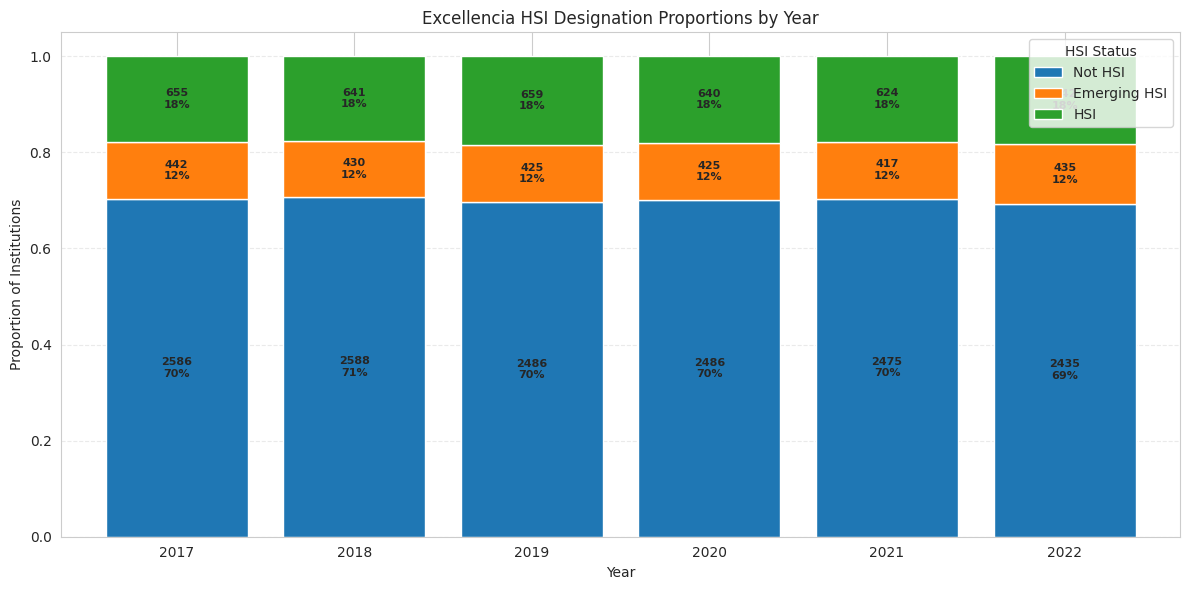

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load updated dataset
df = pd.read_csv("/content/modeling_with_hsi_combined_updated.csv", low_memory=False)
df.columns = df.columns.str.strip().str.lower()

# Drop year 2022 if desired (optional)
# df = df[df['year'] != 2022]

# Drop rows with missing HSI status
df = df[df['excellencia_hsi_status'].notna()]

# Filter out weird sectors (same as before)
excluded_sectors = [
    'Private for-profit less-than-two-year', 'Private for-profit two-year',
    'Private for-profit four-year or above', 'Public less-than two-year',
    'Administrative unit', 'Sector unknown (not active)'
]
df = df[~df['sector'].isin(excluded_sectors)]

# Order for plotting
order = ['Not HSI', 'Emerging HSI', 'HSI']
df['excellencia_hsi_status'] = pd.Categorical(df['excellencia_hsi_status'], categories=order, ordered=True)

# Count + proportion tables
count_tbl = df.groupby(['year', 'excellencia_hsi_status']).size().unstack(fill_value=0).reindex(columns=order)
prop_tbl = count_tbl.div(count_tbl.sum(axis=1), axis=0)

# === Absolute Count Plot ===
ax = count_tbl.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Excellencia HSI Designation Counts by Year')
plt.ylabel('Number of Institutions')
plt.xlabel('Year')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=0)
plt.legend(title='HSI Status')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8, weight='bold')

plt.tight_layout()
plt.show()

# === Proportion Plot ===
ax2 = prop_tbl.plot(kind='bar', stacked=True, figsize=(12, 6), width=0.8)
plt.title('Excellencia HSI Designation Proportions by Year')
plt.ylabel('Proportion of Institutions')
plt.xlabel('Year')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='HSI Status', loc='upper right')

for i, (index, row) in enumerate(prop_tbl.iterrows()):
    y_offset = 0
    for status in order:
        proportion = row[status]
        count = count_tbl.loc[index, status]
        if proportion > 0.03:
            ax2.annotate(f'{count}\n{proportion:.0%}',
                         (i, y_offset + proportion / 2),
                         ha='center', va='center', fontsize=8, weight='bold')
        y_offset += proportion

plt.tight_layout()
plt.show()

